In [2]:
from elasticsearch import Elasticsearch, helpers
from elasticsearch_dsl import Search
import warnings
warnings.filterwarnings("ignore")


client = Elasticsearch(
    "https://host.docker.internal:9200",
    verify_certs=False,
    basic_auth=("elastic", "9xO=+o01BLploNBezWbf"))
client.info()['version']

{'number': '8.8.0',
 'build_flavor': 'default',
 'build_type': 'docker',
 'build_hash': 'c01029875a091076ed42cdb3a41c10b1a9a5a20f',
 'build_date': '2023-05-23T17:16:07.179039820Z',
 'build_snapshot': False,
 'lucene_version': '9.6.0',
 'minimum_wire_compatibility_version': '7.17.0',
 'minimum_index_compatibility_version': '7.0.0'}

# Zadania 3-7

In [41]:
# Tworzenie ineksu. Definicja zmiennej settings, zawierającej analyzery i mapping zawierającej strukturę indeksu.
settings = {
    "analysis": {
      "filter": {
        "polish_synonim": {
          "type": "synonym",
          "synonyms": [
            "styczeń, sty, I",
            "luty, lut, II",
            "marzec, mar, III",
            "kwiecień, kwi, IV",
            "maj, V",
            "czerwiec, cze, VI",
            "lipiec, lip, VII",
            "sierpień, sie, VIII",
            "wrzesień, wrz, IX",
            "październik, paź, X",
            "listopad, lis, XI",
            "grudzień, gru, XII"
          ]
        }
      },
      "analyzer": {
        "polish_analyzer": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": ["polish_synonim",
                     "lowercase",
                     "morfologik_stem",
                     "lowercase"]
        },
        "polish_analyzer_2": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": ["lowercase",
                     "morfologik_stem",
                     "lowercase"]
        }
      }
    }
  }
mappings = {
    "properties": {
      "text_with_synonyms": {
        "type": "text",
        "analyzer": "polish_analyzer"
      },
      "text_standard": {
        "type": "text",
        "analyzer": "polish_analyzer_2"
      }
    }
  }

In [3]:
#Tworzenie indeksu
client.indices.create(index="polish_text", settings=settings, mappings=mappings)
#client.indices.delete(index="polish_text")

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'polish_text'})

In [3]:
#Parsowanie danych
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')['corpus'].to_pandas()

df = pd.DataFrame(dataset)
data = []
for index, row in df.iterrows():
    data.append(row)

In [4]:
#Dodawanie danych do indeksu
actions = [
    {
        "_op_type": "index",
        "_index": "polish_text",
        "_source": {
            "text_with_synonyms": item["text"],
            "text_standard": item["text"]
        }
    }
    for item in data
]
helpers.bulk(client, actions)

(57638, [])

In [42]:
#Tworzenie i wykonywanie zapytań zliczających dokumenty zawierjące 'styczeń' do elasticsearch.
q1 = {
  "query": {
    "match": {
      "text_with_synonyms": {
        "query": "styczeń",
        "analyzer": "polish_analyzer"
      }
    }
  }
}
q2 = {
  "query": {
    "match": {
      "text_standard": {
        "query": "styczeń",
        "analyzer": "polish_analyzer_2"
      }
    }
  }
}

c1 = client.count(index="polish_text", body = q1)['count']
c2 = client.count(index="polish_text", body = q2)['count']

In [43]:
print("Liczba dokumentów zawierających słowo 'styczeń', analyzer z synonimami:", c1)
print("Liczba dokumentów zawierających słowo 'styczeń', analyzer bez synonimów:", c2)

Liczba dokumentów zawierających słowo 'styczeń', analyzer z synonimami: 44155
Liczba dokumentów zawierających słowo 'styczeń', analyzer bez synonimów: 329


Znaleziona w pierwszym przypadku, ogromna liczba dokumentów, które pasują do wyszukiwania, spowodowana jest synonimem styczeń, I, przez który praktycznie wszystkie dokumenty zostają zaklasyfikowane do zawierających słowo "styczeń". Liczba osiągnięta dla drugiego analyzera, bez synonimów, wydaje się być bliska prawdy.

# Zadanie 8 - 9

In [44]:
# Tworzenie ineksu do zadania 8-9. Tworzę 4 analyzery, z lematyzacją i synonimami, z samą lematyzacją, z samymi synonimami i bez lematyzacji i synonimów.
settings_2 = {
    "analysis": {
      "filter": {
        "polish_synonim": {
          "type": "synonym",
          "synonyms": [
            "styczeń, sty, I",
            "luty, lut, II",
            "marzec, mar, III",
            "kwiecień, kwi, IV",
            "maj, V",
            "czerwiec, cze, VI",
            "lipiec, lip, VII",
            "sierpień, sie, VIII",
            "wrzesień, wrz, IX",
            "październik, paź, X",
            "listopad, lis, XI",
            "grudzień, gru, XII"
          ]
        }
      },
      "analyzer": {
        "analyzer_s_l": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": ["polish_synonim",
                     "lowercase",
                     "morfologik_stem",
                     "lowercase"]
        },
        "analyzer_s": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": ["polish_synonim",
                     "lowercase"]
        },
        "analyzer_l": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": ["lowercase",
                     "morfologik_stem",
                     "lowercase"]
        },
        "analyzer": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": ["lowercase"]
        }
      }
    }
  }
mappings_2 = {
    "properties": {
      "text_s_l": {
        "type": "text",
        "analyzer": "analyzer_s_l"
      },
      "text_s": {
        "type": "text",
        "analyzer": "analyzer_s"
      },
      "text_l": {
        "type": "text",
        "analyzer": "analyzer_l"
      },
      "text": {
        "type": "text",
        "analyzer": "analyzer"
      }
    }
  }

In [8]:
# Tworzenie indeksu do zadania 8-9
client.indices.create(index="qa_index", settings=settings_2, mappings=mappings_2)
#client.indices.delete(index="qa_index")

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'qa_index'})

In [6]:
# Pobieranie potrzebnych datasetów
dataset_questions = load_dataset("clarin-knext/fiqa-pl",'queries')['queries'].to_pandas()
dataset_test = load_dataset("clarin-knext/fiqa-pl-qrels", 'corpus')['test'].to_pandas()

In [7]:
dataset_questions.head()

,_id,title,text
0,0,,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...


In [8]:
dataset_test.head()

,query-id,corpus-id,score
0,8,566392,1
1,8,65404,1
2,15,325273,1
3,18,88124,1
4,26,285255,1


In [12]:
# Wysyłanie danych do indeksu.
actions2 = [
    {
        "_op_type": "index",
        "_index": "qa_index",
        "_source": {
            "text_s_l": item["text"],
            "text_s": item["text"],
            "text_l": item["text"],
            "text": item["text"],
            "title": item["title"],
            "id": item["_id"]
        }
    }
    for item in data
]

helpers.bulk(client, actions2)

(57638, [])

In [46]:
# Deklarowanie funkcji użytecznych do wykonywanie zapytań do elasticserach, a także do wyciągania danych z odpowiedzi.
import math
def search_best_answers(client, index_name, question, analyzer, text):
    query_body = {
        "size": 5,
        "query": {
            "match": {
                text: {
                    "query": question,
                    "analyzer": analyzer
                }
            }
        },
        "_source": ["id"]
    }
    response = client.search(index=index_name, body=query_body)
    return [hit["_source"]["id"] for hit in response['hits']['hits']]

def count_ncdg5(ids_returned, ids_correct):
    DCG = 0
    for i in range(5):
        if int(ids_returned[i]) in ids_correct:
            DCG += 1/math.log(i+2,2)
    IDCG = 0
    for i in range(min(len(ids_correct), 5)):
        IDCG += 1/math.log(i+2, 2)
    return DCG/IDCG

def count_answers_for_each_analyzer(question):
    tab = []
    tab.append(search_best_answers(client, "qa_index", question, "analyzer_s_l", "text_s_l"))
    tab.append(search_best_answers(client, "qa_index", question, "analyzer_s", "text_s"))
    tab.append(search_best_answers(client, "qa_index", question, "analyzer_l", "text_l"))
    tab.append(search_best_answers(client, "qa_index", question, "analyzer", "text"))
    return tab

def count_result_from_each_analyzer(tab, ids_correct):
    values = []
    for result in tab:
        values.append((count_ncdg5(result, ids_correct), result))
    return values

In [47]:
# Wykonywanie zapytań, do elasticserach.
import numpy as np
results = []
for id in dataset_test["query-id"].unique():
    question = dataset_questions[dataset_questions['_id'] == str(id)]["text"].to_list()[0]
    answers = count_answers_for_each_analyzer(question)
    res = count_result_from_each_analyzer(answers, dataset_test[dataset_test["query-id"] == id]["corpus-id"].to_list())
    results.append(res)

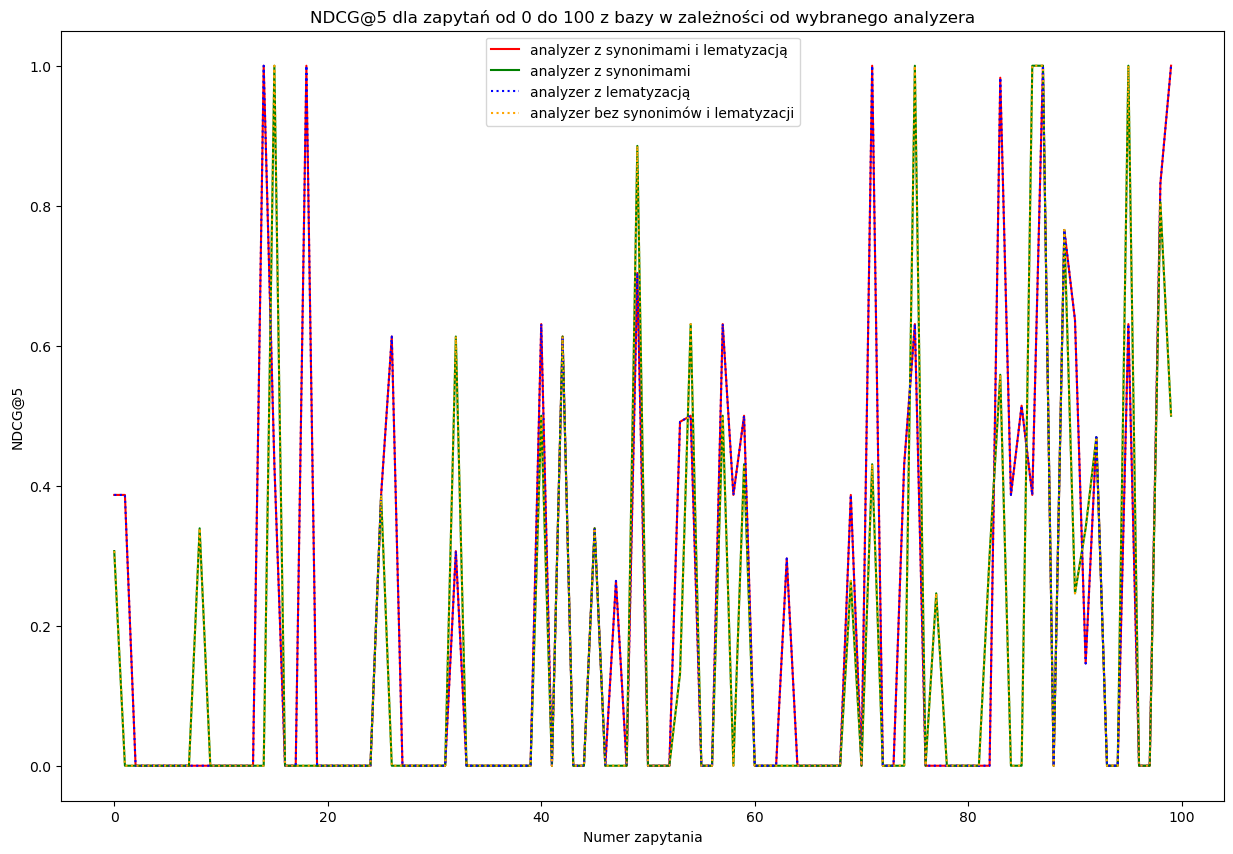

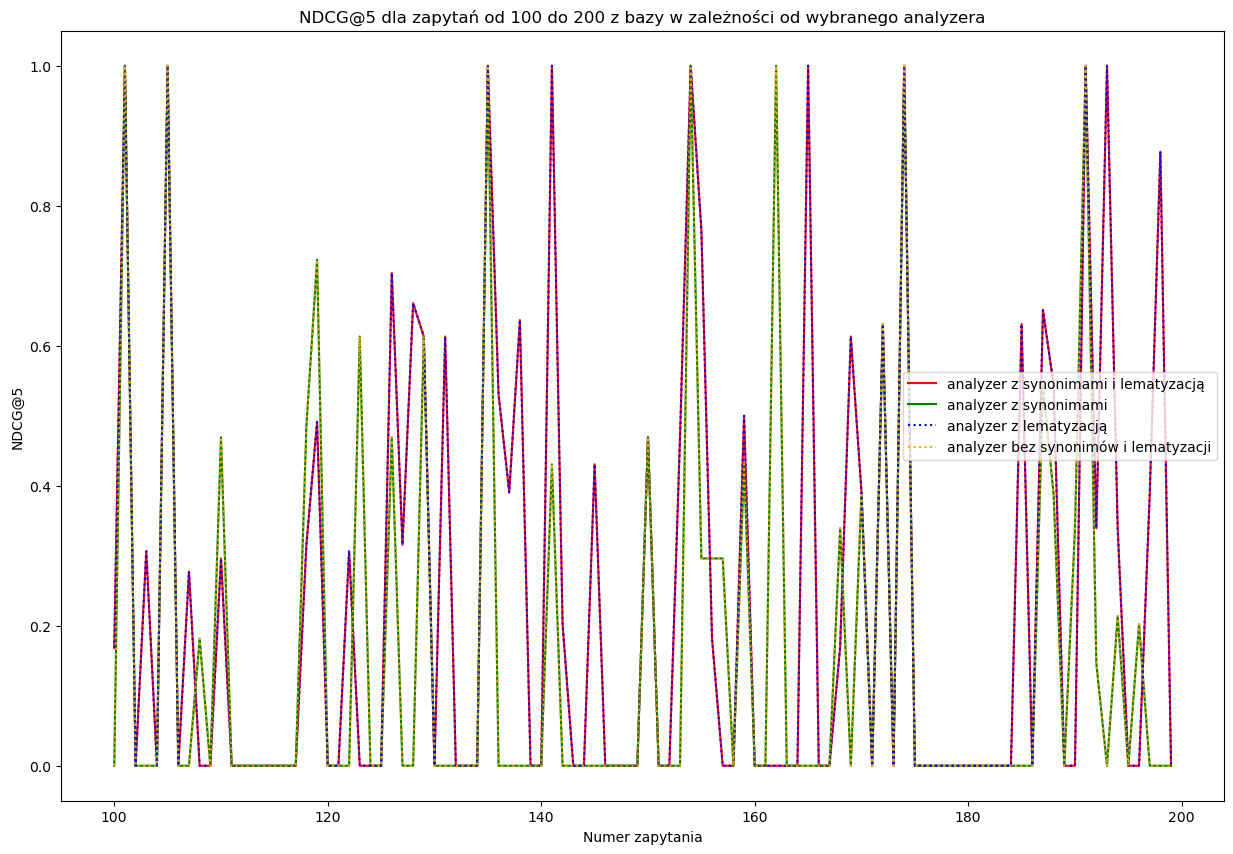

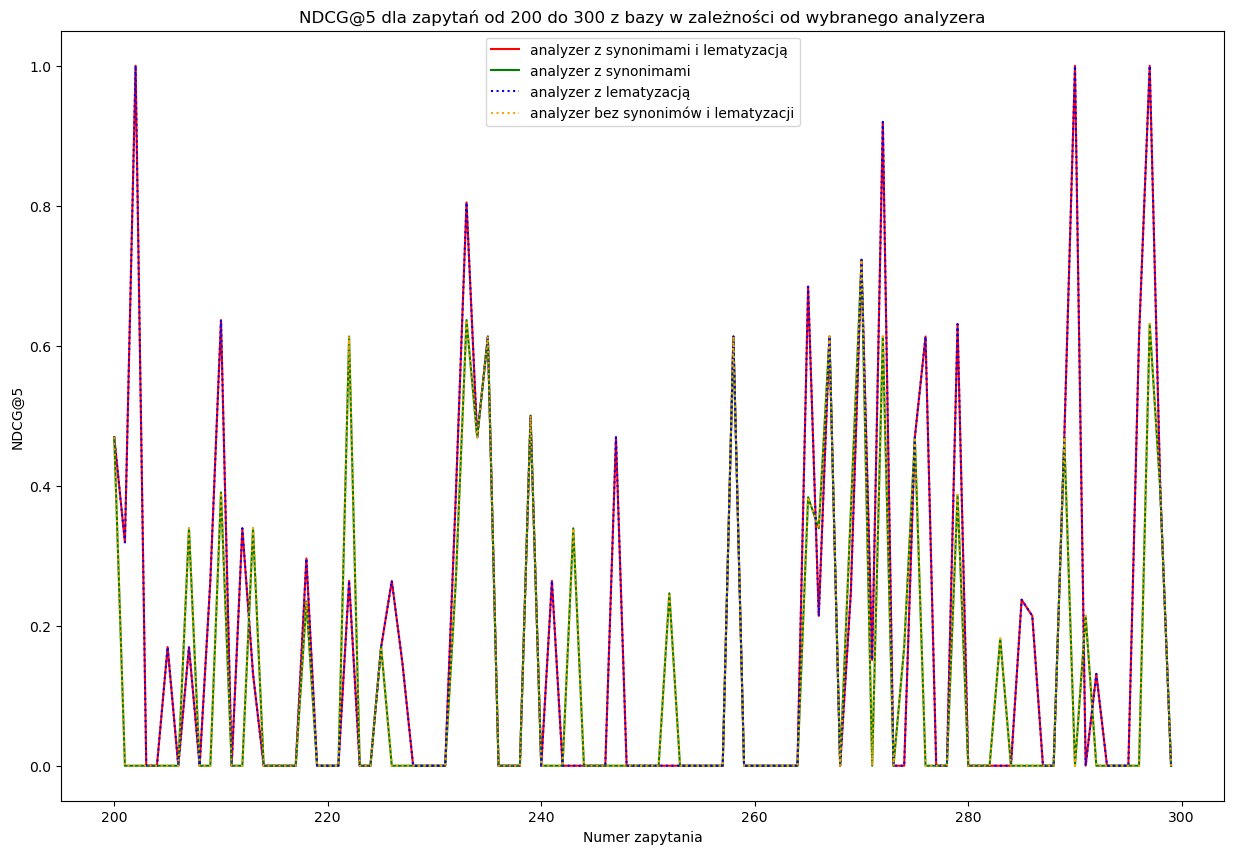

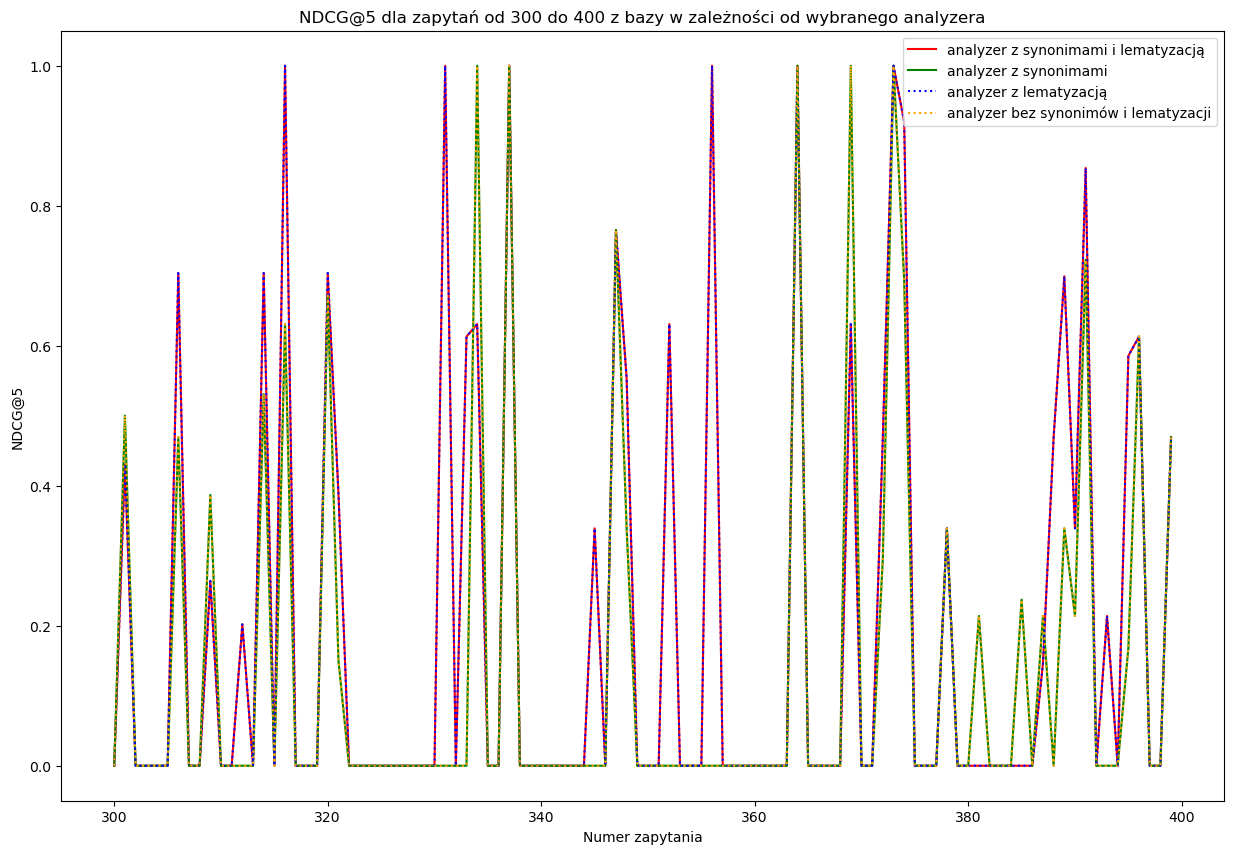

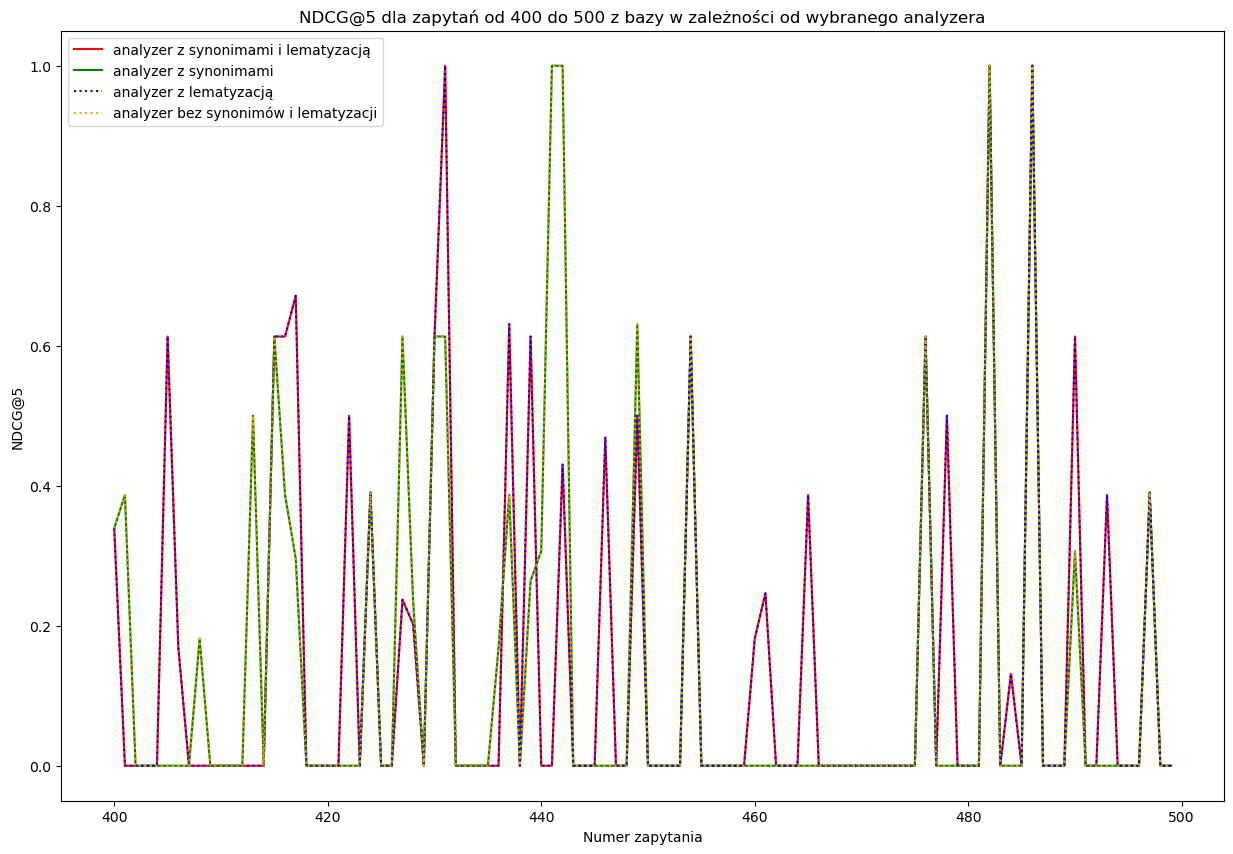

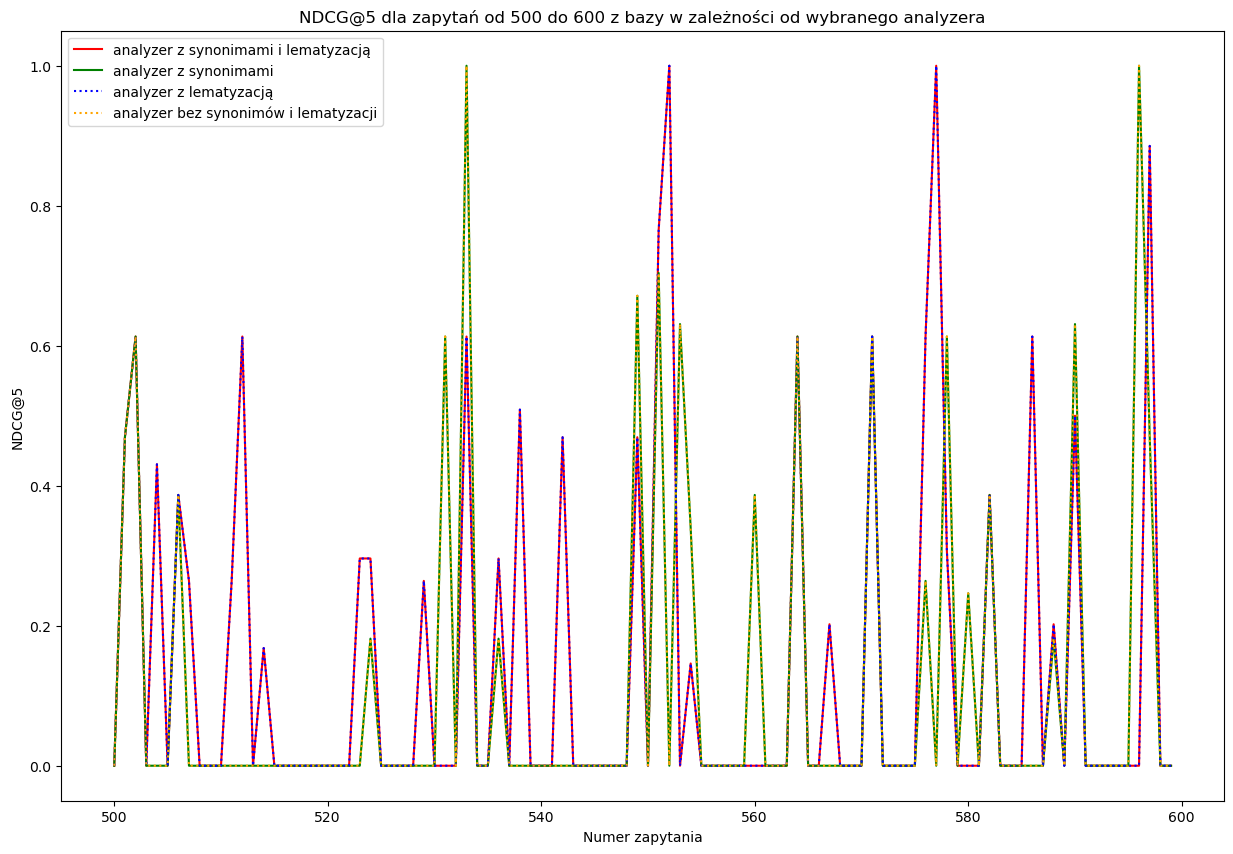

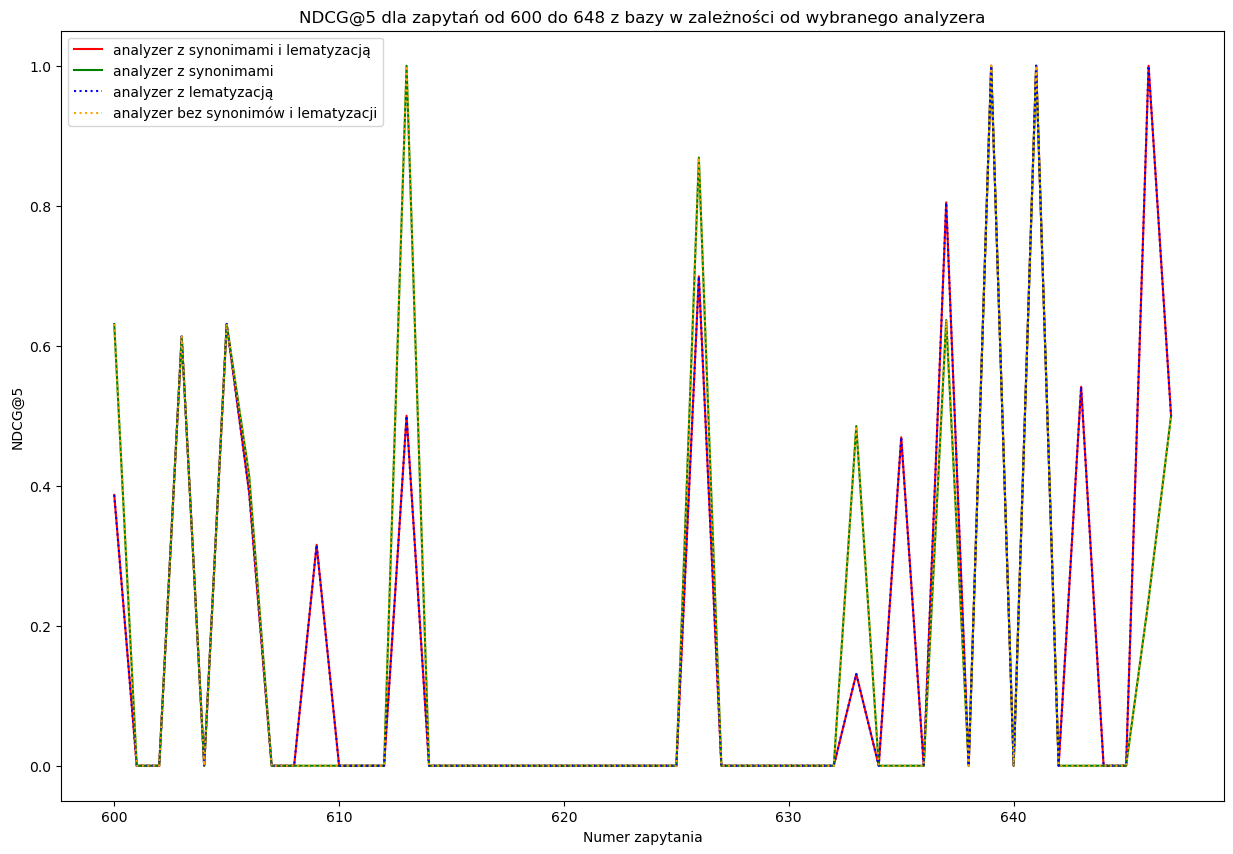

In [99]:
#Wyświetlanie wykresów z wynikami.
import matplotlib.pyplot as plt
result_values = np.zeros((len(results), 4))
for i in range(len(results)):
    result_values[i][0] = results[i][0][0]
    result_values[i][1] = results[i][1][0]
    result_values[i][2] = results[i][2][0]
    result_values[i][3] = results[i][3][0]

def display_plot(start, end):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_xlabel("Numer zapytania")
    ax.set_ylabel("NDCG@5")
    ax.set_title(f"NDCG@5 dla zapytań od {start} do {end} z bazy w zależności od wybranego analyzera")
    ax.plot(list(range(start, end)), result_values[start:end,0], linestyle = '-', color = "red")
    ax.plot(list(range(start, end)), result_values[start:end,1], linestyle = '-', color = "green")
    ax.plot(list(range(start, end)), result_values[start:end,2], linestyle = 'dotted', color = "blue")
    ax.plot(list(range(start, end)), result_values[start:end,3], linestyle = 'dotted', color = "orange")
    ax.legend(["analyzer z synonimami i lematyzacją", "analyzer z synonimami", "analyzer z lematyzacją", "analyzer bez synonimów i lematyzacji"])
    plt.show()

display_plot(0, 100)
display_plot(100, 200)
display_plot(200, 300)
display_plot(300, 400)
display_plot(400, 500)
display_plot(500, 600)
display_plot(600, 648)

Jak widać na wykresach powyżej, wyniki uzyskane dla analyzera z synonimami i lematyzacją, są tożsame z wynikami dla analyzera z lematyzacją, bez synonimów. Wyniki analyzerów: wykorzystującego synonimy, bez lematyzacji i nie wykorzystującego zarówno lematyzacji i synonimów są identyczne, jednak różnią się od wyników dwóch analyzerów omówionych na początku. Do pierwszej grupy analyzerów będę się w dalszej części sprawozdania odnosił jako analyzery z lematyzacją, a do drugiej jako analyzery bez lematyzacji.

Jak widać na wykresach, bardzo ciężko porównać na nich wyniki uzyskane przez obie grupy analyzerów. W niektórych pytaniach lepiej poradziły sobie analyzery z lematyzacją, w innych analyzery bez lematyzacji. Wiarygodną metryką pozwalającą na porównanie obu grup jest średnia arytmetyczna i mediana wyników:

In [36]:
analyzers = ["analyzer z synonimami i lematyzacją", "analyzer z synonimami", "analyzer z lematyzacją", "analyzer bez synonimów i lematyzacji"]
print("Mediana wyników dla poszczególnych analyzerów:")
for i in range(len(analyzers)):
    print(analyzers[i] + ":", np.median(result_values, axis = 0)[i])
print("-----------------------------------")
print("Średnia wyników dla poszczególnych analyzerów:")
for i in range(len(analyzers)):
    print(analyzers[i] + ":", np.mean(result_values, axis = 0)[i])

Mediana wyników dla poszczególnych analyzerów:
analyzer z synonimami i lematyzacją: 0.0
analyzer z synonimami: 0.0
analyzer z lematyzacją: 0.0
analyzer bez synonimów i lematyzacji: 0.0
-----------------------------------
Średnia wyników dla poszczególnych analyzerów:
analyzer z synonimami i lematyzacją: 0.18512911307977398
analyzer z synonimami: 0.13854570378524383
analyzer z lematyzacją: 0.18512911307977398
analyzer bez synonimów i lematyzacji: 0.13854570378524383


Mediana dla wszystkich analyzerów jest równa 0. Średnia dla analyzerów z lematyzacją jest większa niż dla analyzerów bez lematyzacji.

# Zadanie 10

In [84]:
results = results
res = [[], [], []]

def analyze_results(question, question_id, res, answers, proper_answers):
    if(len(proper_answers) != 1):
        return res
    for i in range(5):
        if int(answers[0][1][i]) in proper_answers:
            if i == 0:
                res[0].append([question, question_id])
                return res
            if i == 3 or i == 4:
                res[1].append([question, question_id])
                return res
            return res
    res[2].append([question, question_id])
    return res

i = 0
for id in dataset_test["query-id"].unique():
    question = dataset_questions[dataset_questions['_id'] == str(id)]["text"].to_list()[0]
    answers = results[i]
    proper_answers = dataset_test[dataset_test["query-id"] == id]["corpus-id"].to_list()
    res = analyze_results(question, id, res, answers, proper_answers)
    i += 1

In [94]:
print("Przykładowe pytanie, w którym istotny dokument został zwrócony jako:")
print("Pierwszy:", res[0][0][0])
print("Czwarty lub piąty:", res[1][2][0])
print("Nie został znaleziony:", res[2][1][0])

Przykładowe pytanie, w którym istotny dokument został zwrócony jako:
Pierwszy: Jak rozliczyć zarobione i wydane pieniądze przed założeniem firmowych kont bankowych?
Czwarty lub piąty: Konsekwencje podatkowe zmiany wartości walut obcych
Nie został znaleziony: 401k Przelew po zamknięciu firmy


## Analiza pytań:

W pytaniu, w którym wartościowa odpowiedź została zwrócona przez elasticserach jako pierwsza, możemy zobaczyć dokładne słowa kluczowe, które umożliwiają w prosty sposób dopasować odpowiedź do pytania. Frazy takie jak "firmowe konta bankowe", "rozliczyć", "zarobione i wydane pieniądze" mogą naprowadzić elasticserch do pożądanych odpowiedzi. 

W pytaniu, w którym wartościowa odpowidź została zwrócona jako czwarta lub piąta, pytanie jest krósze niż w przypadku poprzednim. Możliwe że słowa kluczowe w nim występujące są również popularne wśród innych odpowiedzi.

W pytaniu w którym elasticsearch nie znalazł wartościowej odpowidzi, widzimy, że pytanie to nie jest pytaniem. Jest krótkie, zawiera mało słów kluczowych. Możliwe, że w zbiorze występuje dużo odpowiedzi na temat firm i przelewów, przez co do pytania nie udało się znaleźć wartościowych odpowiedzi.

# Odpowiedzi na zadane pytania:

### What are the strengths and weaknesses of regular expressions versus full text search regarding processing of text?

Wyrażenia regularne bardzo dobrze sprawdziły się w wyszukiwaniu tekstu, o określonej strukturze(takiej tak data/godzina). Regexy nieźle poradziły sobie z wyszukaniem wystąpienia słowa "styczeń", jednak cała procedura jest nieporównywalnie prostsza z użyciem elasticserach a analyzerem wykorzystującym lematyzację. Dzięki temu, nie trzeba zastanawiać się jak efektywnie zapisać wszystkie formy "styczeń", wystrczy jedynie napisać proste zapytanie do elasticserach. 

Silne strony regexów -> wyszukiwanie tekstu o określonej strukturze, dość łatwo się je pisze i szybko działają
Słabe strony regexów -> nie poradzą sobie w zadaniach jak "wyszukaj które pytania najlepiej odpowiadają na zadane pytanie", nie wyciągną z tekstu nic ponad to co w nich zapiszemy.

silne strony elasticsearch -> po dodaniu tesktu do elasticsearch, możemy wykonywać na nim wiele różnych zapytań. Można w nim zastosować wiele przydatnych narzędzi takie jak lematyzacja, użycie synonimów
słabe strony elasticsearch -> konieczność uruchomienia środowiska do pracy, dane trzeba wgrać do uprzednio zaprojektowanego indeksu, aby poprawnie z nich korzystać. Dodatkowo zapewne trudniej byłoby nam wykonać zadania z poprzednich laboratoriów korzystając z elasticsearch. Moglibyśmy mieć duży problem z wyszukaniem dat i godzin.

----
### Is full text search applicable to the question answering problem? Show at least 3 examples from the corpus to support your claim.

Według mnie osiągnięte wyniki wyszukiwania odpowiedzi na zadane pytania, są bardzo dobre. Elasticsearch poradził sobie z zadanym zadaniem bardzo dobrze. Co prawda istniały pytania, dla których nie był w stanie zwrócić poprawnych odpowiedzi, jednak fakt, że na podstawie jedynie tokenów pytania, był w stanie szybko zwrócić często bardzo dobre jakościowo indesky pasujących do pytania odpowiedzi był dla mnie zaskakujący.

3 Pytania w który elasticsearch poradził sobie bardzo dobrze(takie w których poprawna odpowiedź znalazła się na 1 miejscu):

In [97]:
print("1:", res[0][0][0])
print("2:", res[0][1][0])
print("3:", res[0][2][0])

1: Jak rozliczyć zarobione i wydane pieniądze przed założeniem firmowych kont bankowych?
2: instytucja finansowa chce podziału członka na jednego członka LLC
3: Jakie są konsekwencje „przeklasyfikowania” IRS zarówno dla pracodawcy, jak i pracownika?
